# Data

There are some data classes in `kgcnn` that can help to store and load graph data. In principle a graph is a collection of the follwing objects in tensor-form:

* `nodes_attributes`: Node features of shape `(N, F)` where N is the number of nodes and F is the node feature dimension.
* `edge_indices`: Connection list of shape `(M, 2)` where M is the number of edges. The indices denote a connection of incoming or receiving node `i` and outgoing or sending node `j` as `(i, j)`.
* `edges_attributes`: Edge features of shape `(M, F)` where M is the number of edges and F is the edge feature dimension.
* `graph_attributes`: Graph state information of shape `(F, )` where F denotes the feature dimension.

These can be stored in form of numpy arrays in a dictionary type container `GraphDict`. Additional train/test assignment, labels, positions/coordinates, forces or momentum, other connection indices or even symbols or IDs can be added to this dictionary. 

For multiple small graphs a list of these dictionaries serves to represent the common case of datasets for supervised learning tasks, for example small molecules or crystal structures.

## Graph dictionary

Graphs are represented by a dictionary `GraphDict` of (numpy) arrays which behaves like a python dict. In principle the `GraphDict` can take every key and value pair via item operator `[]`. However, for consitency and class methods, keys must be names and values `np.ndarray` . You can use `set` and `get` to out-cast to numpy arrays or run `validate()`. 

In [1]:
import numpy as np
from kgcnn.data.base import GraphDict
# Single graph.
graph = GraphDict({"edge_indices": np.array([[1, 0], [0, 1]]), "node_label":  np.array([[0], [1]])})
graph.set("graph_labels",  np.array([0]))
graph.set("edge_attributes", np.array([[1.0], [2.0]]));
print({key: value.shape for key, value in graph.items()})
print("Is dict: %s" % isinstance(graph, dict))
print("Graph label", graph["graph_labels"])

{'edge_indices': (2, 2), 'node_label': (2, 1), 'graph_labels': (1,), 'edge_attributes': (2, 1)}
Is dict: True
Graph label [0]


The class `GraphDict` can be converted to for example a strict graph representation of `networkx` which keeps track of node and edge changes.

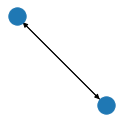

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
nx_graph = graph.to_networkx()
plt.figure(figsize=(1.5,1.5)) 
nx.draw(nx_graph)
plt.show()

Or compiling a dictionary of (tensorial) graph properties from a `networkx` graph.

In [3]:
graph = GraphDict().from_networkx(nx.cubical_graph())
print({key: value.shape for key, value in graph.items()})

{'node_number': (8,), 'edge_indices': (12, 2)}


There are graph pre- and postprocessors in `kgcnn.graph` which take specific properties by name and apply a processing function or transformation. The processing function can for example compute angle indices based on edges or sort edge indices and sort dependent features accordingly. 

> **WARNING**: However, they should be used with caution since they only apply to tensor properties regardless of any underlying graph.


For example `SortEdgeIndices` can sort an "edge_indices" tensor and sort attributed properties such as "edge_attributes" or "edge_labels" or a list of multiple (named) properties accordingly. In the example below a generic search string is also valid. To directly update a `GraphDict` make a preprocessor with `in_place=True` .

In [4]:
from kgcnn.graph.preprocessor import SortEdgeIndices, AddEdgeSelfLoops, SetEdgeWeightsUniform

SortEdgeIndices(edge_indices="edge_indices", edge_attributes="^edge_(?!indices$).*", in_place=True)(graph)
SetEdgeWeightsUniform(edge_indices="edge_indices", value=1.0, in_place=True)(graph)
AddEdgeSelfLoops(
    edge_indices="edge_indices", edge_attributes="^edge_(?!indices$).*", 
    remove_duplicates=True, sort_indices=True, fill_value=0, in_place=True)(graph);

print({key: value.shape for key, value in graph.items()})

{'node_number': (8,), 'edge_indices': (20, 2), 'edge_weights': (20, 1)}


## Graph list

A `MemoryGraphList` should behave identical to a python list but contain only `GraphDict` items.

## Datasets

## Model input

> **note**: You can find this page as jupyter notebook in https://github.com/aimat-lab/gcnn_keras/tree/master/notebooks/docs . 